## ch07. 앙상블 학습 

### 다수결 투표 방식 

In [1]:
## 연습용 데이터 적재 하기 
## 위스콘신 유방암 데이터세트 

import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

In [2]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


0 열: 환자의 고유 아이디 넘버

1 열: 종양의 악성/양성 여부 (M =악성, B =양성)

2~31 열: 세포 핵의 이미지로 부터 추출된 측성값

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:,2:].values
y = df.iloc[:,1].values

sc = StandardScaler()
le = LabelEncoder()

X = sc.fit_transform(X)
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [48]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(C=1)
dt = DecisionTreeClassifier()
sc = SVC(C=1, gamma=0.01,kernel='rbf',probability=True)

lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
sc.fit(X_train, y_train)

clf = [lr,dt,sc]
clf_label = ['Logistic Regression','Decision Tree','Support Vector Classifier']

In [49]:
import numpy as np

for meta, label in zip(clf, clf_label):
    score = cross_val_score(meta,X_test,y_test,cv=10)
    mean_score = np.mean(score)
    print('%s:%.3f'%(label, mean_score))

Logistic Regression:0.983
Decision Tree:0.953
Support Vector Classifier:0.971


앙상블 모델 적용 이전 각각의 개별 분류기들의 성능

In [52]:
from sklearn.ensemble import VotingClassifier 
from sklearn.metrics import accuracy_score

clf = [('lr',lr),('dt',dt),('sc',sc)]

vc = VotingClassifier(estimators=clf, voting='soft')

vc.fit(X_train, y_train)

y_pred = vc.predict(X_test)

print('다수결 투표 모델 정확도:%.3f'%accuracy_score(y_true=y_test, y_pred=y_pred))

다수결 투표 모델 정확도:0.988


개별 메타 분류기를 결합해 만든 앙상블 모델의 모델 정확도 

voting='soft' 로 설정하여 개별 메타 분류기가 예측한 레이블 값이 아닌, 확률값을 기반으로 최종 결과값을 계산한다. 

반대로 voting='hard' 로 설정하면 개별 분류기의 결과값을 레이블 값으로 받고 그걸 기반으로 다수결 투표를 진행함. 

또한 VotingClassifier 메소드는 estimator 에 쓰일 개별 분류기 집합을 튜플 형태의 배열을 인자값으로 받는다는 점에 유의

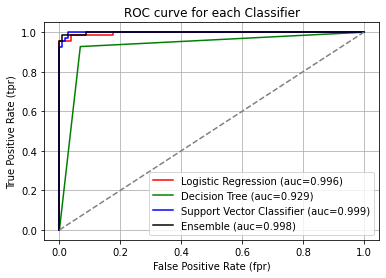

In [121]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc

lists = [lr,dt,sc,vc]
list_labels = ['Logistic Regression','Decision Tree','Support Vector Classifier','Ensemble']
colors = ['red','green','blue','black']

for meta, labels,c in zip(lists,list_labels,colors):
    meta.fit(X_train, y_train)
    y_pred = meta.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,y_score=y_pred)
    auc_score = auc(fpr,tpr)
    plt.plot(fpr, tpr,color=c, label='%s (auc=%.3f)'%(labels, auc_score))
    
plt.grid()
plt.xlabel('False Positive Rate (fpr)')
plt.ylabel('True Positive Rate (tpr)')
plt.title('ROC curve for each Classifier')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--',color='gray')

그래프 그릴때 주의할것 : 서포트 벡터 머신 생성시 SVC(probability=True)를 지정해줘야 결과값으로 레이블 값이 아닌 레이블 소속 

확률을 반환함!

### 배깅 기법을 통한 앙상블 모델 구축

In [72]:
from sklearn.ensemble import BaggingClassifier 

bag = BaggingClassifier(base_estimator=lr, bootstrap=True, bootstrap_features=False)

bag.fit(X_train, y_train)

y_pred = bag.predict(X_test)

print('로지스틱회귀 배깅 모델의 정확도: %.3f'%accuracy_score(y_pred=y_pred, y_true=y_test))

로지스틱회귀 배깅 모델의 정확도: 0.965


BaggingClassifier 메소드는 한가지 종류의 base_estimator 을 받아서 중복 샘플 추출을 통해 모델을 학습시킨다. 

In [74]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=None, random_state=1)
bag_tree = BaggingClassifier(base_estimator=tree,n_estimators=500,max_features=1.0,max_samples=1.0)

bag.fit(X_train, y_train)

y_pred = bag.predict(X_test)

print('결정트리 배깅 모델의 정확도: %.3f'%accuracy_score(y_pred=y_pred, y_true=y_test))

결정트리 배깅 모델의 정확도: 0.971


### 부스팅 기법을 활용한 앙상블 모델 구축 

#### XGBoost 모델

In [125]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, disable_default_eval_metric= 1)

param_grid={'booster' :['gbtree'],
                 'gamma':[0,1,2,3],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['binary:logistic'],
                 'random_state':[2]}

gs = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=10, scoring='accuracy')


gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     disable_default_eval_metric=1, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrain...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use

In [104]:
print('최적 파라미터 값들:%s\n'%gs.best_params_)
print('XGBoost 모델 정확도:%.3f'%gs.best_score_)

최적 파라미터 값들:{'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'gamma': 1, 'n_estimators': 50, 'objective': 'binary:logistic', 'random_state': 2}

XGBoost 모델 정확도:0.965


### 스태킹 기법을 활용한 앙상블 모델

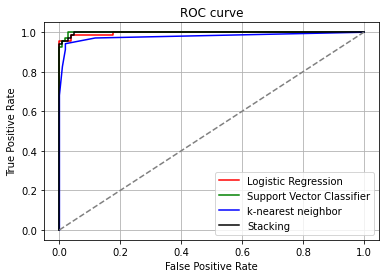

In [124]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression(C=1)
sc = SVC(C=1, gamma=0.01,kernel='rbf',probability=True)
knn = KNeighborsClassifier(n_neighbors=5) 

base_learners = [('lr',lr),('sc',sc),('knn',knn)]

stacking = StackingClassifier(estimators=base_learners, final_estimator=lr, cv=10)

lists = [lr,sc,knn,stacking]
list_labels = ['Logistic Regression','Support Vector Classifier','k-nearest neighbor','Stacking']
colors = ['red','green','blue','black']

for clf, label, c in zip(lists, list_labels, colors):
    clf.fit(X_train, y_train) 
    prob = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,y_score=prob)
    plt.plot(fpr, tpr,color=c, label='%s'%(label))

plt.plot([0,1],[0,1],linestyle='--',color='gray')
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')